# Word2Vec

Using only the raw text, we'll derive and explore the semantic properties of its words.

## Imports

Python code in one module gains access to the code in another module by the process of importing it. The import statement is the most common way of invoking the import machinery, but it is not the only way.

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("txtdata\*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['txtdata\\deutschland.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'txtdata\deutschland.txt'...
Corpus is now 183693 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The Parliamentary Council, meeting in public session at Bonn am Rhein on 23 May 1949, confirmed
that the Basic Law for the Federal Republic of Germany, which was adopted by the Parliamentary
Council on 8 May 1949, was ratified in the week of 16 to 22 May 1949 by the parliaments of more than
two thirds of the participating German Länder.
['The', 'Parliamentary', 'Council', 'meeting', 'in', 'public', 'session', 'at', 'Bonn', 'am', 'Rhein', 'on', 'May', 'confirmed', 'that', 'the', 'Basic', 'Law', 'for', 'the', 'Federal', 'Republic', 'of', 'Germany', 'which', 'was', 'adopted', 'by', 'the', 'Parliamentary', 'Council', 'on', 'May', 'was', 'ratified', 'in', 'the', 'week', 'of', 'to', 'May', 'by', 'the', 'parliaments', 'of', 'more', 'than', 'two', 'thirds', 'of', 'the', 'participating', 'German', 'L', 'nder']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 28,636 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2019-10-23 15:07:05,002 : INFO : collecting all words and their counts
2019-10-23 15:07:05,003 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-23 15:07:05,014 : INFO : collected 2804 word types from a corpus of 28636 raw words and 960 sentences
2019-10-23 15:07:05,018 : INFO : Loading a fresh vocabulary
2019-10-23 15:07:05,026 : INFO : min_count=3 retains 1153 unique words (41% of original 2804, drops 1651)
2019-10-23 15:07:05,030 : INFO : min_count=3 leaves 26539 word corpus (92% of original 28636, drops 2097)
2019-10-23 15:07:05,079 : INFO : deleting the raw counts dictionary of 2804 items
2019-10-23 15:07:05,081 : INFO : sample=0.001 downsamples 53 most-common words
2019-10-23 15:07:05,082 : INFO : downsampling leaves estimated 16429 word corpus (61.9% of prior 26539)
2019-10-23 15:07:05,098 : INFO : estimated required memory for 1153 words and 300 dimensions: 3343700 bytes
2019-10-23 15:07:05,102 : INFO : resetting layer weights


In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 1153


**Start training, this might take a minute or two...**

In [20]:
thrones2vec.train(sentences, total_words=token_count, epochs = 10 )

2019-10-23 15:07:05,366 : INFO : training model with 2 workers on 1153 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-10-23 15:07:05,875 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-23 15:07:06,015 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-23 15:07:06,017 : INFO : EPOCH - 1 : training on 28636 raw words (16380 effective words) took 0.5s, 34005 effective words/s
2019-10-23 15:07:06,323 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-23 15:07:06,423 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-23 15:07:06,424 : INFO : EPOCH - 2 : training on 28636 raw words (16435 effective words) took 0.4s, 42324 effective words/s
2019-10-23 15:07:06,669 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-23 15:07:06,822 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-23 15:07:06,823 : INFO : EPOCH - 

(164361, 286360)

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-10-23 15:07:09,491 : INFO : saving Word2Vec object under trained\thrones2vec.w2v, separately None
2019-10-23 15:07:09,493 : INFO : not storing attribute vectors_norm
2019-10-23 15:07:09,494 : INFO : not storing attribute cum_table
C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-10-23 15:07:09,656 : INFO : saved trained\thrones2vec.w2v


## Explore the trained model.

In [23]:
print(thrones2vec.most_similar('state', topn=5))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-10-23 15:07:09,747 : INFO : precomputing L2-norms of word weight vectors


[('defence', 0.9892354011535645), ('during', 0.9196568727493286), ('termination', 0.8774966597557068), ('months', 0.8774100542068481), ('person', 0.8525954484939575)]


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=3, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.wv.syn0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], coords[2])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "z"]
)

In [28]:
points.head(100)

,word,x,y,z
0,Service,-16.003191,-2.523550,-2.864701
1,provided,-15.715423,-2.635608,-2.356486
2,by,-1.164369,-2.911791,11.510847
3,the,-10.594146,-7.560274,-0.260440
4,Federal,-13.785260,-3.797527,-0.765902
5,Ministry,-16.260862,-2.410128,-3.368277
6,of,-10.597098,-7.580886,-0.266704
7,Justice,-16.408085,-2.291325,-3.901338
8,and,-11.647346,0.097207,-5.713326
9,Consumer,-16.376051,-2.340941,-3.672306


In [29]:
sns.set_context("poster")

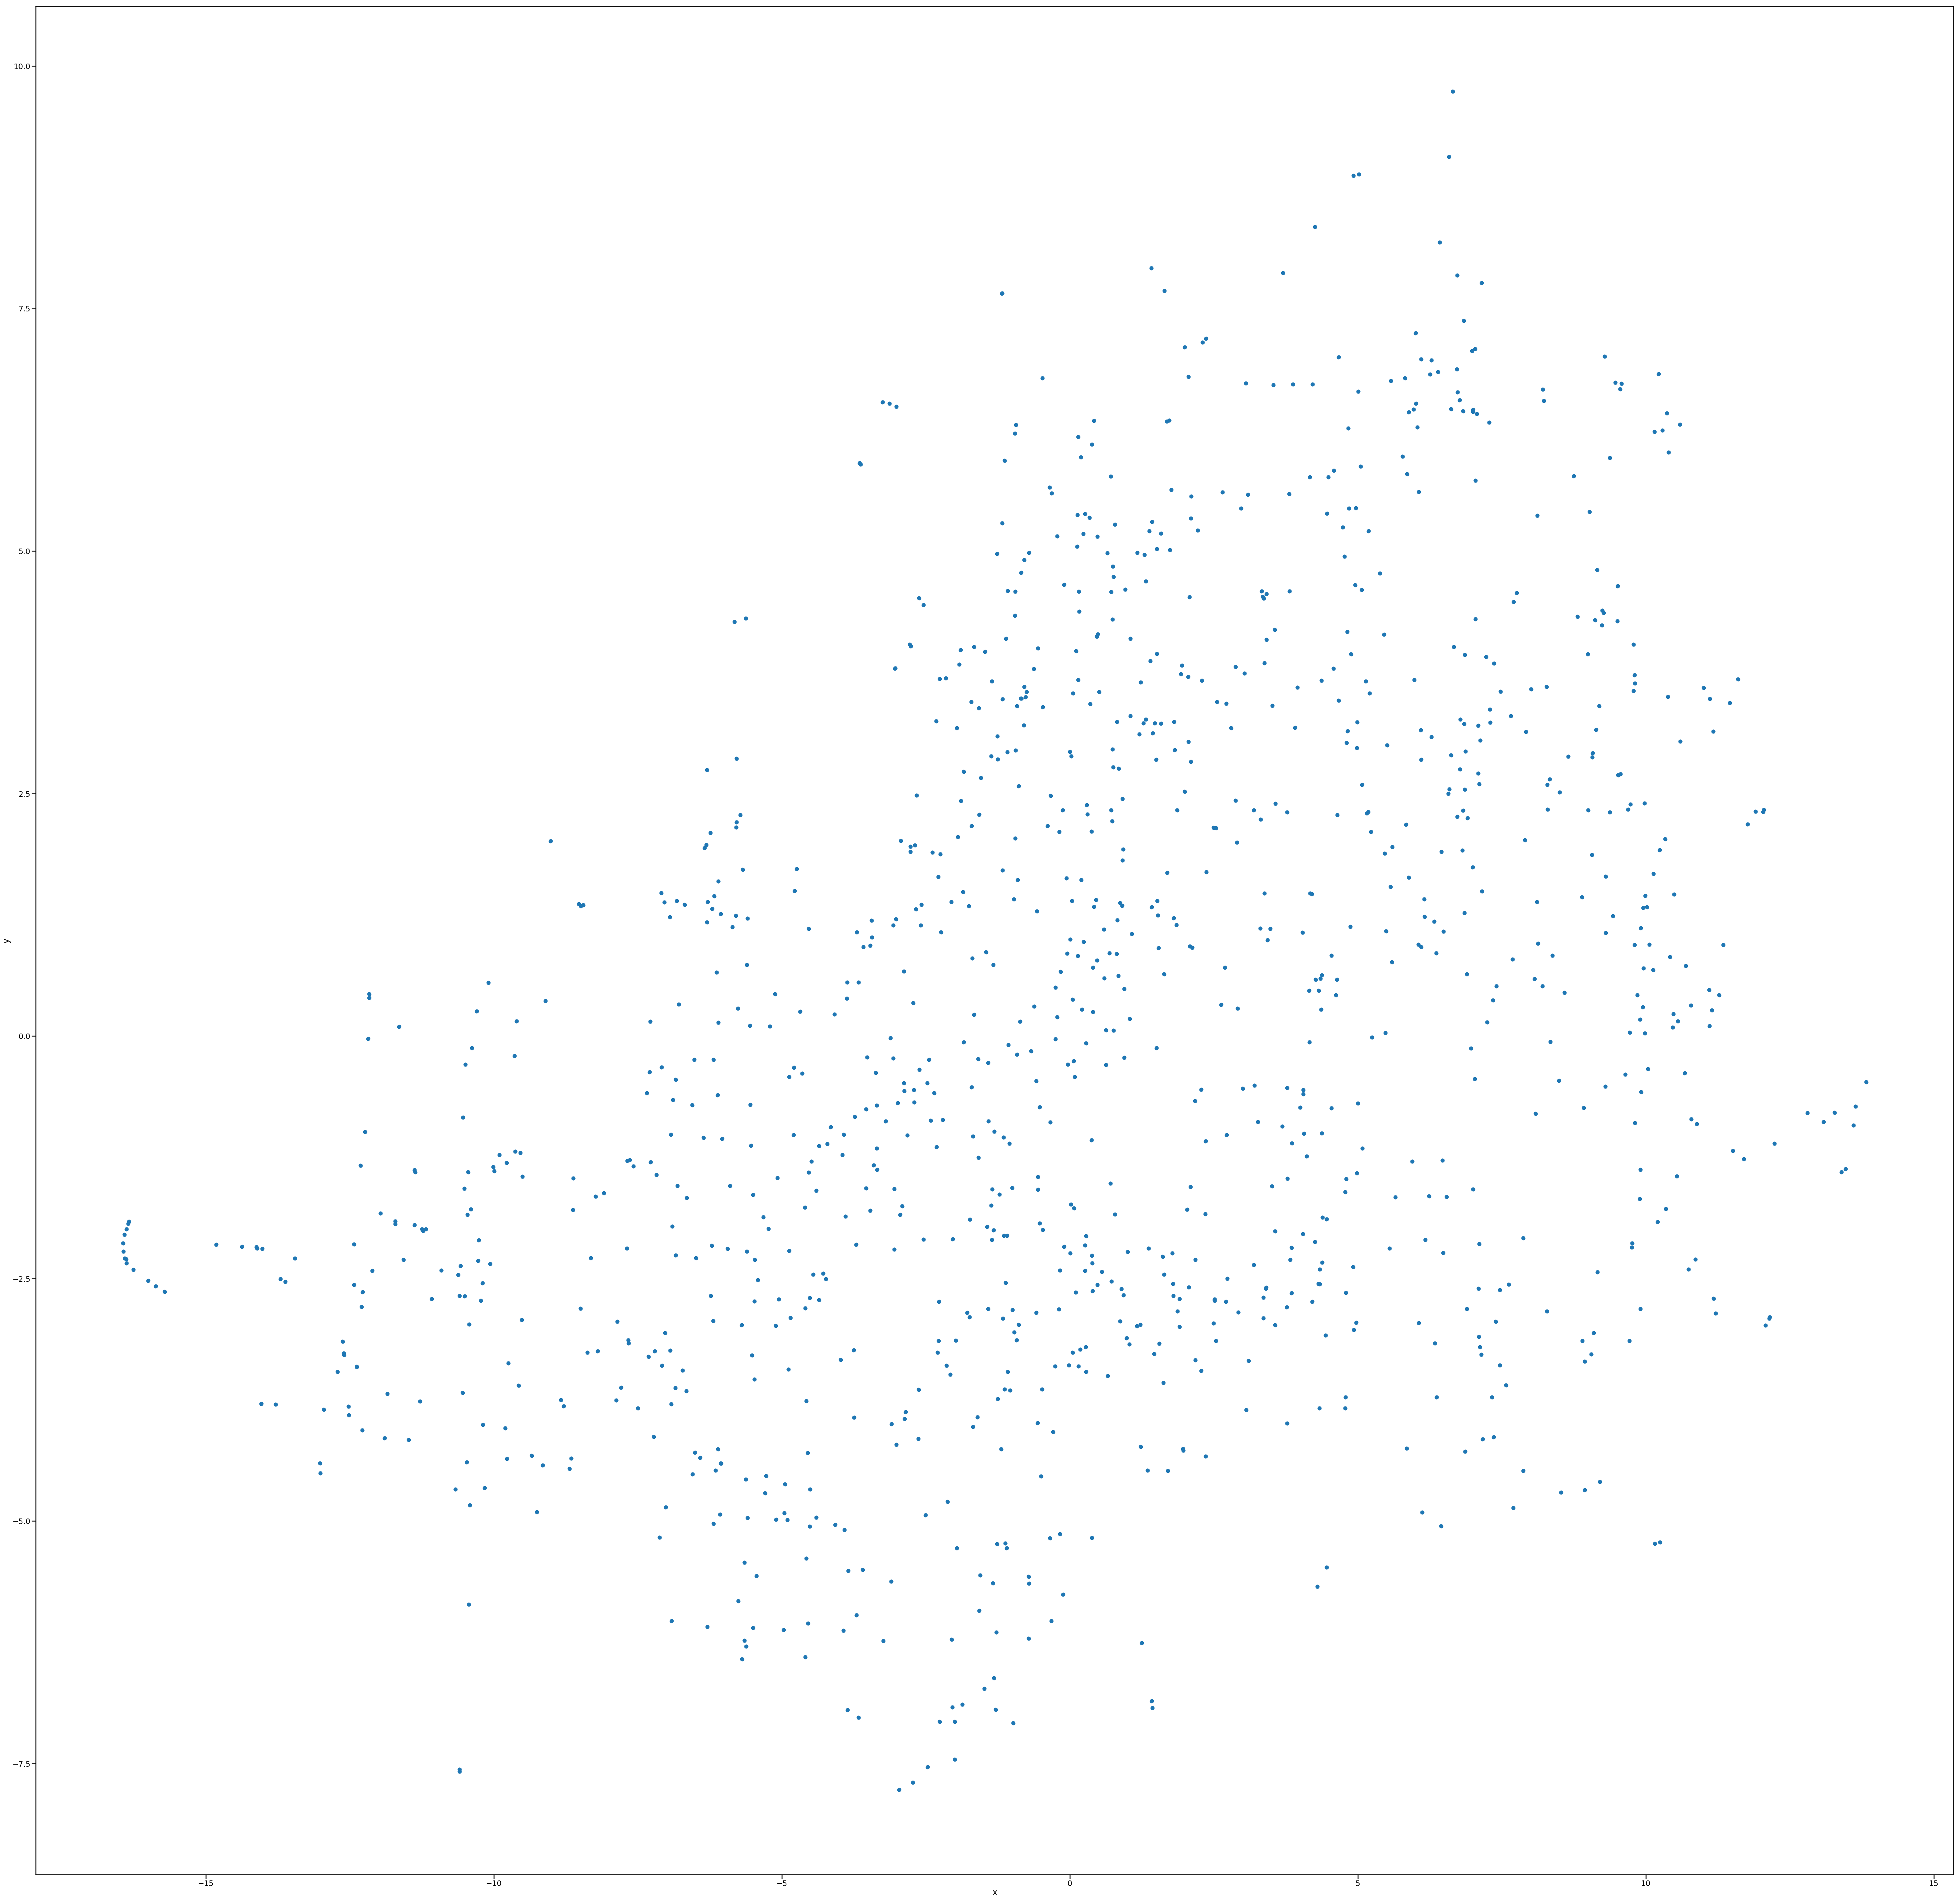

In [30]:
points.plot.scatter("x", "y", s=100, figsize=(100, 100))

**Zoom in to some interesting places**

In [31]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

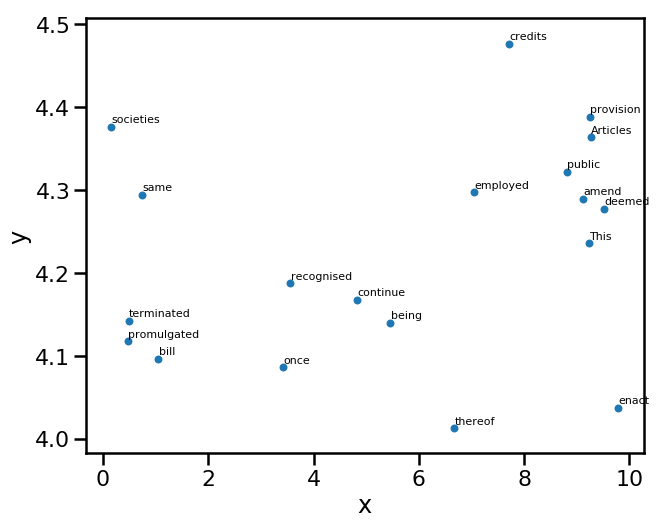

In [32]:
plot_region(x_bounds=(0, 10), y_bounds=(4, 4.5))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

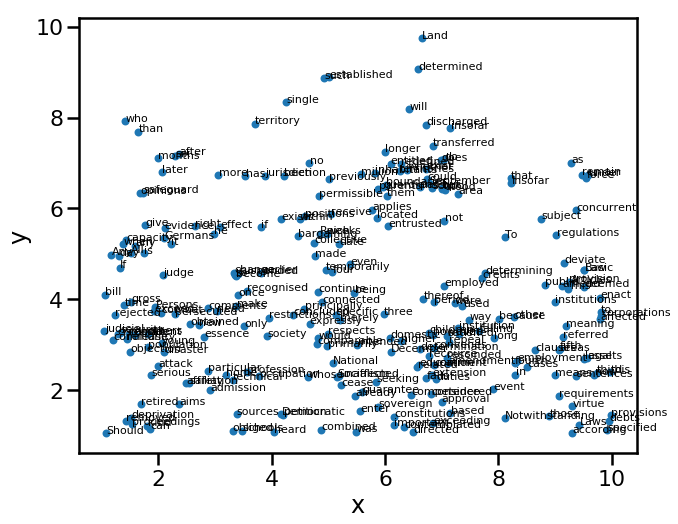

In [33]:
plot_region(x_bounds=(1, 10), y_bounds=(1, 10))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [34]:
thrones2vec.most_similar("power")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('exclusive', 0.975191593170166),
 ('matters', 0.9506959319114685),
 ('legislate', 0.9467936754226685),
 ('legislative', 0.9343830347061157),
 ('have', 0.9162161946296692),
 ('concurrent', 0.9091569185256958),
 ('respect', 0.8421252965927124),
 ('subject', 0.8362330198287964),
 ('powers', 0.8361727595329285),
 ('right', 0.8164058923721313)]

In [35]:
thrones2vec.most_similar("capital")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('obligations', 0.9949976205825806),
 ('borrowing', 0.9930645823478699),
 ('Europe', 0.9928650259971619),
 ('external', 0.9927341341972351),
 ('VIII', 0.9924380779266357),
 ('endanger', 0.992058515548706),
 ('limits', 0.9915115833282471),
 ('Combined', 0.9913396835327148),
 ('enjoy', 0.991047203540802),
 ('interests', 0.9907232522964478)]

In [36]:
thrones2vec.most_similar("money")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('As', 0.997824490070343),
 ('total', 0.997512936592102),
 ('agree', 0.997363805770874),
 ('allocation', 0.9972273111343384),
 ('estate', 0.9963948726654053),
 ('structure', 0.9958212971687317),
 ('ratio', 0.9944398403167725),
 ('justice', 0.9941228032112122),
 ('July', 0.9940518736839294),
 ('granting', 0.9931383728981018)]

**Linear relationships between word pairs**

In [37]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [38]:
nearest_similarity_cosmul("capital", "worker", "industry")
nearest_similarity_cosmul("worker", "party", "state")
nearest_similarity_cosmul("money", "wealth", "city")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


KeyError: "word 'industry' not in vocabulary"

In [ ]:
thrones2vec.most_similar(positive=['state'], negative=['people'])